# RNN을 이용한 SMS Spam 분류
- 캐글에서 제공하는 [스팸메일 데이터](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 파일 업로드

In [4]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving spam.csv to spam (1).csv


### 데이터 전처리

In [5]:
df = pd.read_csv(filename, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [6]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
# ham: 0, spam: 1로 대체, LabelEncoding으로도 가능
df['v1'] = df['v1'].replace(['ham', 'spam'], [0, 1])    
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [8]:
# Null 값이 있는지 확인
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [9]:
# 데이터 중복이 있는지 확인
df['v2'].nunique()

5169

In [10]:
# 데이터 중복 제거
df = df.drop_duplicates('v2', keep='first')

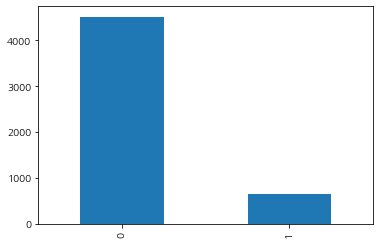

In [11]:
df['v1'].value_counts().plot(kind='bar');

In [12]:
df['v1'].value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [13]:
X_data = df['v2'].values
y_data = df['v1'].values
print(f'메일 본문의 개수: {len(X_data)}')
print(f'레이블의 개수: {len(y_data)}')

메일 본문의 개수: 5169
레이블의 개수: 5169


In [14]:
X_data.shape

(5169,)

In [15]:
t = Tokenizer()
t.fit_on_texts(X_data)
sequences = t.texts_to_sequences(X_data)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 8921


In [18]:
X_data = sequences

### 전체 데이터셋의 길이를 임의의 숫자(=100)에 맞춤

In [19]:
# 전체 데이터셋의 길이를 max_len(=189)에 맞춤
data = pad_sequences(X_data, maxlen=100)    # padding='pre'가 없으므로 뒤에 패딩
data.shape

(5169, 100)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=2021
)

In [28]:
X_train.shape, X_test.shape

((4135, 100), (1034, 100))

### 모델 정의/설정/학습

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32))             # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          285472    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 5s 70ms/step - loss: 0.3762 - accuracy: 0.8750 - val_loss: 0.1172 - val_accuracy: 0.9770
Epoch 2/10
56/56 [==============================] - 4s 66ms/step - loss: 0.1015 - accuracy: 0.9747 - val_loss: 0.0620 - val_accuracy: 0.9855
Epoch 3/10
56/56 [==============================] - 4s 67ms/step - loss: 0.0518 - accuracy: 0.9878 - val_loss: 0.0544 - val_accuracy: 0.9855
Epoch 4/10
56/56 [==============================] - 4s 69ms/step - loss: 0.0350 - accuracy: 0.9905 - val_loss: 0.1501 - val_accuracy: 0.9492
Epoch 5/10
56/56 [==============================] - 4s 66ms/step - loss: 0.0865 - accuracy: 0.9716 - val_loss: 0.0684 - val_accuracy: 0.9819
Epoch 6/10
56/56 [==============================] - 4s 71ms/step - loss: 0.0185 - accuracy: 0.9947 - val_loss: 0.0746 - val_accuracy: 0.9758
Epoch 7/10
56/56 [==============================] - 4s 68ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.0766 - val_accuracy: 0.9807
Epoch 8/10
56

In [33]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

33/33 - 0s - loss: 0.0539 - accuracy: 0.9874
Accuracy: 0.9874


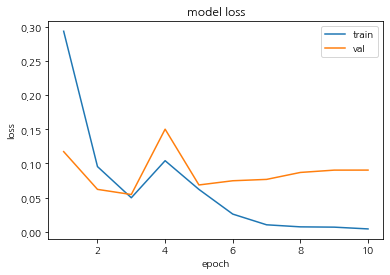

In [34]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()